# Investigating Fandango Movie Ratings
----

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading. In short, the displayed rating tends to be higher than the actual rating given. 

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

What we are aiming to do is to see whether any change has been made after Hickey's article was published.



### Prerequisite
#### 1. Importing the necessary modules and CSV

In [18]:
#Importing the modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

#Visualization settings
%matplotlib inline
sns.set_style('white')

In [2]:
#Importing the csv
fandango=pd.read_csv('fandango_score_comparison.csv')
movieratings=pd.read_csv('movie_ratings_16_17.csv')

In [3]:
#Previewing fandango scores
fandango.sample(5)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
5,The Water Diviner (2015),63,62,50,6.8,7.2,4.5,4.0,3.15,3.10,...,3.60,3.0,3.0,2.5,3.5,3.5,34,39373,397,0.5
32,The Hunting Ground (2015),92,72,77,7.8,7.5,4.5,4.1,4.60,3.60,...,3.75,4.5,3.5,4.0,4.0,4.0,6,1196,42,0.4
48,Fantastic Four (2015),9,20,27,2.5,4.0,3.0,2.7,0.45,1.00,...,2.00,0.5,1.0,1.5,1.5,2.0,421,39838,6288,0.3
58,Seventh Son (2015),12,35,30,3.9,5.5,3.5,3.2,0.60,1.75,...,2.75,0.5,2.0,1.5,2.0,3.0,126,41177,1213,0.3
47,Annie (2014),27,61,33,4.8,5.2,4.5,4.2,1.35,3.05,...,2.60,1.5,3.0,1.5,2.5,2.5,108,19222,6835,0.3


In [4]:
#Previewing movie ratings
movieratings.sample(5)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
106,Max Steel,2016,22,4.6,0,38,3.5,1.10,2.30,0.00,1.90,1.0,2.5,0.0,2.0
198,The Whole Truth,2016,46,6.1,29,33,3.0,2.30,3.05,1.45,1.65,2.5,3.0,1.5,1.5
122,Nine Lives,2016,11,5.3,11,42,4.0,0.55,2.65,0.55,2.10,0.5,2.5,0.5,2.0
92,Kubo and the Two Strings,2016,84,7.9,97,87,4.5,4.20,3.95,4.85,4.35,4.0,4.0,5.0,4.5
158,The 9th Life of Louis Drax,2016,41,6.3,40,34,3.5,2.05,3.15,2.00,1.70,2.0,3.0,2.0,1.5


#### 2. Data Selection
Since we are trying to find whether there are changes post-Hickey's analysis, we will need the following columns:

- For the data set with ratings previous to Hickey's analysis, select the following columns: 'FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference'.
- For the other data set, select the the following columns: 'movie', 'year', 'fandango'.

In [5]:
#Selecting the necessary columns for fandango
keep1=['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 
       'Fandango_votes', 'Fandango_Difference']
fandango_before=fandango.loc[:,keep1]
fandango_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


One little modification that we might need to do is to isolate the years on the movies into a separate column to make it easier further on.

In [6]:
fandango_before['year']=fandango_before['FILM'].str.extract(r'\((\d+)\)',expand=False).astype(int)
fandango_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [7]:
#Selecting the necessary columns for movie ratings
keep2=['movie', 'year', 'fandango']
fandango_after=movieratings.loc[:,keep2]
fandango_after.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

### Changing the Goal of our Analysis
At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

### Selecting the Data
With this new research goal, we have two populations of interest:

1. All Fandango's ratings for popular movies released in 2015.
2. All Fandango's ratings for popular movies released in 2016.

Since popular is a vague word, we are going to use Hickey's definition in which a movie which has 30 or more fan votes on Fandango

In [8]:
#Checking if the definition holds for the first dataset
sum(fandango_before['Fandango_votes']>=30)*100/fandango_before.shape[0]

100.0

Hickey's definition will hold true for his own dataset (100% of the data has 30 or more votes, but what about the other data set? Since the second dataset has no column or indication for votes, we cannot easily prove it. However, we can sample some movies and then check fandango's website to see if the movies can be considered as 'popular'. Sadly however, at the time of doing this project, I cannot find any star ratings on Fandango's website (they only display Rotten Tomatoes' rating), thus I must rely on the given solution.

In [9]:
fandango_after.sample(10,random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Above we used a value of 1 as the random seed. This is good practice because it suggests that we weren't trying out various random seeds just to get a favorable sample.

As of April 2018, these are the fan ratings we found:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-amwm">Movie</th>
    <th class="tg-amwm">Fan ratings</th>
  </tr>
  <tr>
    <td class="tg-baqh">Mechanic: Resurrection</td>
    <td class="tg-baqh">2247</td>
  </tr>
  <tr>
    <td class="tg-baqh">Warcraft</td>
    <td class="tg-baqh">7271</td>
  </tr>
  <tr>
    <td class="tg-baqh">Max Steel</td>
    <td class="tg-baqh">493</td>
  </tr>
  <tr>
    <td class="tg-baqh">Me Before You</td>
    <td class="tg-baqh">5263</td>
  </tr>
  <tr>
    <td class="tg-baqh">Fantastic Beasts and Where to Find Them</td>
    <td class="tg-baqh">13400</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Cell</td>
    <td class="tg-yw4l">17</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Genius</td>
    <td class="tg-yw4l">127</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Sully</td>
    <td class="tg-yw4l">11877</td>
  </tr>
  <tr>
    <td class="tg-yw4l">A Hologram for the King	</td>
    <td class="tg-yw4l">500</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Captain America: Civil War</td>
    <td class="tg-yw4l">35057</td>
  </tr>
</table>


90% of the movies in our sample are popular. This is enough and we move forward with a bit more confidence.

What we need to do now is to isolate the data from Hickey's data set for movies released in 2015 and movies released in 2016 for the second data set.

In [10]:
#Checking movie release year for Hickey's set
fandango_before['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

As we can see, we do not need movies released in 2014, thus dropping them can be a possible solution.

In [11]:
fandango_before=fandango_before[fandango_before['year']==2015]
fandango_before['year'].value_counts()

2015    129
Name: year, dtype: int64

After that, we can check the second data set. The second data set are made of movies that were released in 2016 and 2017. For the purpose of this research, we only need movies that are released in 2016.

In [12]:
fandango_after=fandango_after[fandango_after['year']==2016]
fandango_after['year'].value_counts()

2016    191
Name: year, dtype: int64

### Analysis
#### 1. Comparing the Distribution

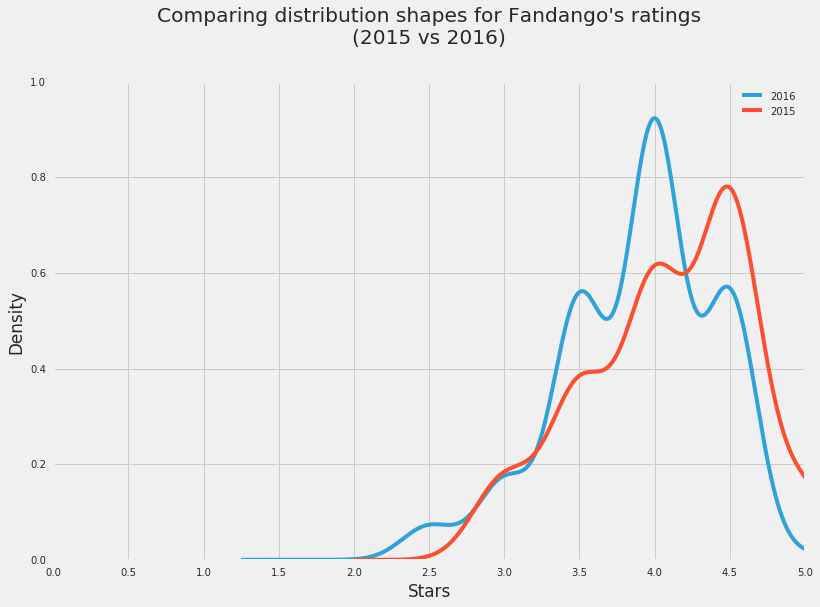

In [20]:
#Using a fivethiryeight styled graph
plt.style.use('fivethirtyeight')

#Plotting
fandango_after['fandango'].plot.kde(label='2016',legend=True,figsize=(12,8))
fandango_before['Fandango_Stars'].plot.kde(label='2015',legend=True)

#Plot settings
plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(np.arange(0,5.1,.5))
plt.show()

Based on the graph above, we can see that both before and after Hickey's article, the ratings have a left-skewed distribution. That being said, in 2016, we can deduce that distribution is somewhat normal with its peak at 4 stars compared to 2015's peak at nearly 4.5 stars. The values for 2016's ratings in general is relatively lower than that of 2015.

#### 2. Comparing Frequencies
One factor that we need to take into account is that the number of movies that we compare is different from 2015 and 2016. We also can display the frequency in a more granular way by using frequency table

In [31]:
print('2015 Fandango ratings frequency'+'\n'+'.'*16)
fandango_before['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

2015 Fandango ratings frequency
................


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [33]:
print('2016 Fandango ratings frequency'+'\n'+'.'*16)
fandango_after['fandango'].value_counts(normalize=True).sort_index()*100

2016 Fandango ratings frequency
................


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

Based on the frequency table above, we can clearly see that there is a significant decrease in rating frequency. In 2015, 4.5's frequency is 38 percent while the year after it decreases to 25 percent. We can also see that there is a decrease in 5-starred movies and increase in other categories.

#### 3. Summary Statistics

In [35]:
#Summary Statistics for 2015
mean1=fandango_before['Fandango_Stars'].mean()
median1=fandango_before['Fandango_Stars'].median()
mode1=fandango_before['Fandango_Stars'].mode()[0]

#Summary Statistics for 2016
mean2=fandango_after['fandango'].mean()
median2=fandango_after['fandango'].median()
mode2=fandango_after['fandango'].mode()[0]

#Combining it into a dataframe
summary = pd.DataFrame()
summary['2015'] = [mean1, median1, mode1]
summary['2016'] = [mean2, median2, mode2]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


([<matplotlib.axis.YTick at 0x7f8485716748>,
 <a list of 11 Text yticklabel objects>)

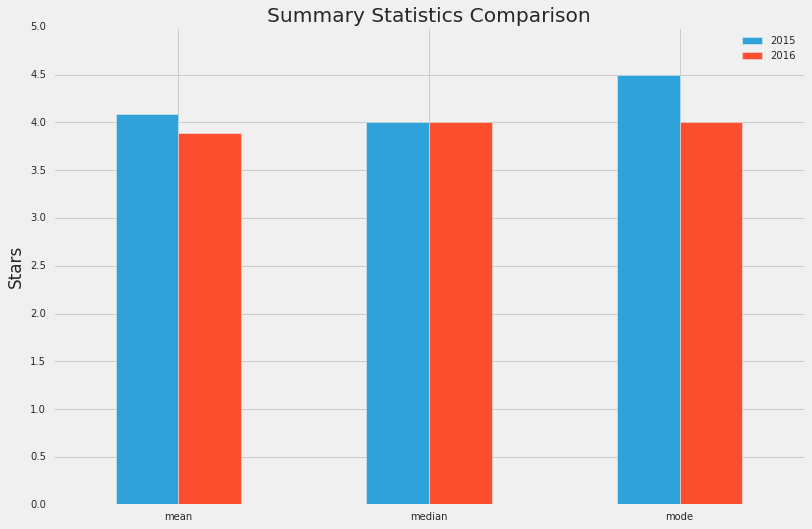

In [48]:
#Plotting a graph for summary statistics
summary.plot.bar(rot=0,legend=True,title='Summary Statistics Comparison',figsize=(12,8))
plt.ylabel('Stars')
plt.ylim(0,5)
plt.yticks(np.arange(0,5.1,.5))

As we can see from both the graph and the table above, there is a drop in the average stars given by approximately 0.2 stars. There is no change in the median stars given but there is a change in the mode of the stars in which in 2015, most of the movies are given 4.5 stars while the year after it decreased to 4 stars.

### Conclusion

To conclude this whole exercise, we can simply say that there is a decrease in Fandango's star rating from 2015 to 2016. The average decrease is 0.2 stars with the mode of the ratings going down from 4.5 to 4 stars.

But it cannot be said for certain that the decrease is influenced by Hickey's article.